<a href="https://colab.research.google.com/github/i-am-parker01/BiDirectional-LSTM-RNN/blob/main/BiDirectionalRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
bilstm_imdb.py
A complete example of Bidirectional LSTM for IMDB sentiment classification using Keras.
Run: python bilstm_imdb.py
"""

'\nbilstm_imdb.py\nA complete example of Bidirectional LSTM for IMDB sentiment classification using Keras.\nRun: python bilstm_imdb.py\n'

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, preprocessing
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

->>> Config / Hyperparameters

In [3]:
VOCAB_SIZE = 20000      # keep top 20k words
MAX_LEN = 200           # max tokens per review
EMBED_DIM = 128
LSTM_UNITS = 128
BATCH_SIZE = 64
EPOCHS = 8
MODEL_DIR = "model_checkpoints"

os.makedirs(MODEL_DIR, exist_ok=True)

-->>> Loading & preparing data

In [4]:
print("Loading IMDB dataset (top %d words)..." % VOCAB_SIZE)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

print("Training samples:", len(x_train), "Test samples:", len(x_test))

# Pad sequences
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN, padding='post', truncating='post')
x_test  = preprocessing.sequence.pad_sequences(x_test,  maxlen=MAX_LEN, padding='post', truncating='post')

# Create validation split
VAL_SPLIT = 0.1
val_size = int(len(x_train) * VAL_SPLIT)
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train2, y_train2 = x_train[val_size:], y_train[val_size:]

print("After split -> train:", x_train2.shape, "val:", x_val.shape, "test:", x_test.shape)

Loading IMDB dataset (top 20000 words)...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 25000 Test samples: 25000
After split -> train: (22500, 200) val: (2500, 200) test: (25000, 200)


# --->>>Model Building

In [5]:
def build_bilstm_model(vocab_size, embed_dim, lstm_units, max_len):
    inp = layers.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len)(inp)
    # Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

In [6]:
model = build_bilstm_model(VOCAB_SIZE, EMBED_DIM, LSTM_UNITS, MAX_LEN)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,839,681 (10.83 MB)

 Trainable params: 2,839,681 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

# --->>>Callbacks

In [7]:
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "bilstm_imdb_best.h5"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# --->>>Training

In [8]:
history = model.fit(
    x_train2, y_train2,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6388 - loss: 0.6042
Epoch 1: val_accuracy improved from -inf to 0.84640, saving model to model_checkpoints/bilstm_imdb_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 324s 908ms/step - accuracy: 0.6391 - loss: 0.6039 - val_accuracy: 0.8464 - val_loss: 0.3825
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8891 - loss: 0.2912
Epoch 2: val_accuracy improved from 0.84640 to 0.85560, saving model to model_checkpoints/bilstm_imdb_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 324s 915ms/step - accuracy: 0.8891 - loss: 0.2911 - val_accuracy: 0.8556 - val_loss: 0.3818
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.9379 - loss: 0.1724
Epoch 3: val_accuracy improved from 0.85560 to 0.85920, saving model to model_checkpoints/bilstm_imdb_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 359s 850ms/step - accuracy: 0.9379 - loss: 0.1724 - val_accuracy: 0.8592 - val_loss: 0.3840
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.9556 - loss: 0.1330
Epoch 4: val_accuracy improved from 0.85920 to 0.85960, saving model to model_checkpoints/bilstm_imdb_best.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 333s 881ms/step - accuracy: 0.9556 - loss: 0.1330 - val_accuracy: 0.8596 - val_loss: 0.3996
Epoch 5/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.9750 - loss: 0.0785
Epoch 5: val_accuracy did not improve from 0.85960
352/352 ━━━━━━━━━━━━━━━━━━━━ 313s 857ms/step - accuracy: 0.9750 - loss: 0.0785 - val_accuracy: 0.8364 - val_loss: 0.4814


# --->>>Evaluating the model...

In [9]:
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f}  Test accuracy: {test_acc:.4f}")



Evaluating on test set...
782/782 - 133s - 171ms/step - accuracy: 0.8338 - loss: 0.4390
Test loss: 0.4390  Test accuracy: 0.8338


# --->>>Predictions and classification report

In [10]:
y_pred_prob = model.predict(x_test, batch_size=256)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

98/98 ━━━━━━━━━━━━━━━━━━━━ 69s 706ms/step

Classification report:
              precision    recall  f1-score   support

           0     0.7873    0.9146    0.8462     12500
           1     0.8982    0.7529    0.8191     12500

    accuracy                         0.8338     25000
   macro avg     0.8427    0.8338    0.8327     25000
weighted avg     0.8427    0.8338    0.8327     25000



#--->>> Confusion matrix

In [11]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[11433  1067]
 [ 3089  9411]]


#--->>> Plotting the training curves

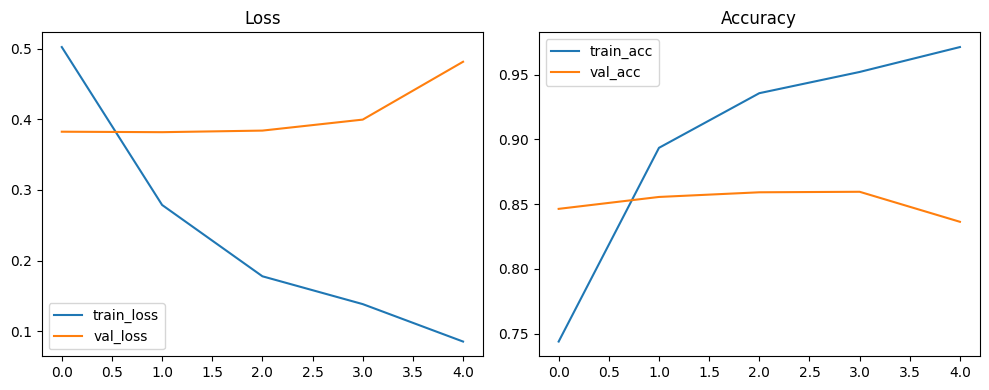

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()

# --->>>>Example inference function

In [13]:
# Load word index for mapping words -> integers (for inference)
word_index = tf.keras.datasets.imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}  # Keras reserves indices 0-3
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

def decode_review(encoded):
    return " ".join(index_word.get(i, "?") for i in encoded if i >= 3)

def predict_text(text, tokenizer_word_index=word_index, model_local=model):
    # Basic tokenization similar to IMDB preprocessing (lowercase + split)
    tokens = text.lower().split()
    encoded = []
    for t in tokens:
        idx = tokenizer_word_index.get(t)
        if idx is None or idx >= VOCAB_SIZE:
            encoded.append(2)  # unknown
        else:
            encoded.append(idx+3)
    padded = preprocessing.sequence.pad_sequences([encoded], maxlen=MAX_LEN)
    prob = model_local.predict(padded)[0][0]
    return prob

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
#Demo of model by providing some sentiments...
demo_text = "Disaster movie"
print("Sample text:", demo_text)
print("Predicted positive probability:", predict_text(demo_text))

Sample text: Disaster movie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted positive probability: 0.57765615


In [18]:
model.save("bilstm_imdb_model.keras")


In [19]:
from google.colab import files
files.download("bilstm_imdb_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>